
<h2 id="Value-at-Risk">Value-at-Risk<a class="anchor-link" href="#Value-at-Risk">¶</a></h2><p>Value at Risk - <strong>VaR</strong> - is one of the most important metrics that is used to measures the risk associated with a financial position or a portfolio of financial instruments. VaR can be defined as the maximum loss with a confidence level over a predetermined period. Let's say that the 1-day 95% VaR of our portfolio is $\$100$. This means that 95% of the time, it is expected that - under normal market conditions - we will not lose more than $100 by holding our portfolio over one day.</p>
<p>Three approaches that are commonly used in the industry are</p>
<ul>
<li><strong>Parametric</strong></li>
<li><strong>Historical Simulation</strong> </li>
<li><strong>Monte Carlo Simulation</strong></li>
</ul>



<h3 id="Import-Libraries">Import Libraries<a class="anchor-link" href="#Import-Libraries">¶</a></h3>


In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from numpy.linalg import multi_dot

from scipy.stats import norm
from tabulate import tabulate

import matplotlib.pyplot as plt


<h3 id="Retrieve-Data">Retrieve Data<a class="anchor-link" href="#Retrieve-Data">¶</a></h3><p>We will use the FAANG stocks as before to build for calculation of VaR</p>


In [6]:
# Load locally stored data
df = pd.read_csv('faang_stocks.csv', parse_dates=True, index_col=0)['2013':]

# Check first 5 values 
df.head()

,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2013-01-02,68.502106,257.309998,28.000000,360.274597,13.144286
2013-01-03,67.637436,258.480011,27.770000,360.483826,13.798572
2013-01-04,65.753418,259.149994,28.760000,367.607117,13.711429
2013-01-07,65.366646,268.459991,29.420000,366.003143,14.171429
2013-01-08,65.542587,266.380005,29.059999,365.280823,13.880000



<h3 id="Calculate-Returns">Calculate Returns<a class="anchor-link" href="#Calculate-Returns">¶</a></h3>


In [7]:
# Calculate daily returns
returns = df.pct_change().dropna()

/Users/aq/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


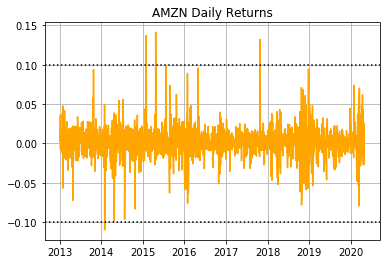

In [8]:
# Visualize AMZN daily returns
plt.plot(returns['AMZN'], color='orange')
plt.axhline(y=0.10, ls='dotted', color='black')
plt.axhline(y=-0.10, ls='dotted', color='black')
plt.title('AMZN Daily Returns')
plt.grid(True)


<h3 id="Parametric-VaR">Parametric VaR<a class="anchor-link" href="#Parametric-VaR">¶</a></h3><p>The Variance-covariance is a parametric method which assumes (almost always) that the returns are normally distributed. In this method, we first calculate the mean and standard deviation of the returns to derive the risk metric. Based on the assumption of normality, we can generalise,
<br/><br/>
$$ VaR = position * (\mu - z * \sigma) $$</p>
<table>
<thead><tr>
<th style="text-align:left">Confidence Level</th>
<th style="text-align:left">Value At Risk     </th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left"><code>90%</code></td>
<td style="text-align:left">$\mu$ - $1.29$ * $\sigma$ </td>
</tr>
<tr>
<td style="text-align:left"><code>95%</code></td>
<td style="text-align:left">$\mu$ - $1.64$ * $\sigma$             </td>
</tr>
<tr>
<td style="text-align:left"><code>99%</code></td>
<td style="text-align:left">$\mu$ - $2.33$ * $\sigma$             </td>
</tr>
</tbody>
</table>
<p>where, $\mu$ is the return, $\sigma$ is the volatility and $z$ is the number of standard deviation from the mean.</p>


In [9]:
# Calculate mean and standard deviation 
mean = np.mean(returns['AMZN'])
stdev = np.std(returns['AMZN'])

# Calculate VaR at difference confidence level
VaR_90 = norm.ppf(1-0.90,mean,stdev)
VaR_95 = norm.ppf(1-0.95,mean,stdev) #norm.ppf(0.05)
VaR_99 = norm.ppf(1-0.99,mean,stdev)

In [10]:
# Ouput results in tabular format
table = [['90%', VaR_90],['95%', VaR_95],['99%', VaR_99] ]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(table,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0230125
95%                      -0.0299292
99%                      -0.0429039



<p>Lets now define a VaR function so that we can use it calculate it for individual stocks</p>


In [11]:
# VaR function
def VaR(symbol, cl=0.95):
    mean = np.mean(returns[symbol])
    stdev = np.std(returns[symbol])
    
    return np.around(100*norm.ppf(1-cl,mean,stdev),4)

In [12]:
# VaR for stocks
print('VaR for FAANG Stocks')
print('---'*11)
[print(f'VaR at 95% CL for {stock:4} : {VaR(stock)}%') for stock in df.columns][0]

VaR for FAANG Stocks
---------------------------------
VaR at 95% CL for AAPL : -2.7758%
VaR at 95% CL for AMZN : -2.9929%
VaR at 95% CL for FB   : -3.4005%
VaR at 95% CL for GOOG : -2.5582%
VaR at 95% CL for NFLX : -4.5729%


**Visualize VaR at 95% confidence level**

download.png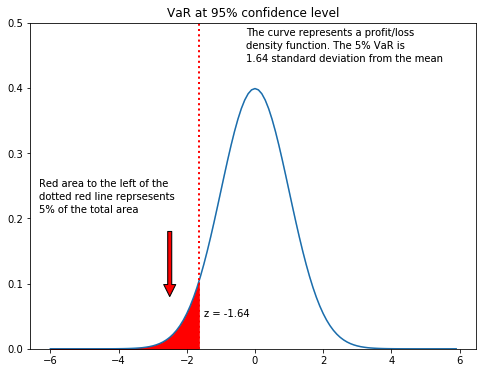


<p>Now, let's assume that we have 1,000 shares of AMZN's stock on April 29, 2020. What is the maximum loss next day with a confidence level of 99%?</p>


In [15]:
num_of_shares = 1000
price = df['AMZN'].iloc[-1]
position = num_of_shares * price 

amzn_var = position * VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var}')

Amazon Holding Value: 2372709.9609375
Amazon VaR at 99% confidence level is: -101798.41813580536



<p>VaR can also be calculated using the above formula at 99% confidence level.</p>


In [16]:
# VaR calculation by appling direct formulae
position * (mean + norm.ppf(1-0.99) * stdev)         # mean-2.33*stdev

-101798.41813580536


<h3 id="Scaling-VaR">Scaling VaR<a class="anchor-link" href="#Scaling-VaR">¶</a></h3><p>Now, let's calculate VaR over a 5-day period. To scale it, multiply by square root of time.
<br/><br/>
$$ VaR = position * (\mu - z * \sigma) * \sqrt{T}$$</p>
<p>where, $T$ is the horizon or forecast period.</p>


In [17]:
forecast_days = 5
f_VaR_90 = VaR_90*np.sqrt(forecast_days)
f_VaR_95 = VaR_95*np.sqrt(forecast_days)
f_VaR_99 = VaR_99*np.sqrt(forecast_days)

In [18]:
ftable = [['90%', f_VaR_90],['95%', f_VaR_95],['99%', f_VaR_99] ]
fheader = ['Confidence Level', '5-Day Forecast Value At Risk']
print(tabulate(ftable,headers=fheader))

Confidence Level      5-Day Forecast Value At Risk
------------------  ------------------------------
90%                                     -0.0514574
95%                                     -0.0669237
99%                                     -0.0959359



<p>Let's now calculate AMZN VaR over a 5-day period with a confidence level of 99%</p>


In [19]:
amzn_var_5days = position * f_VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var_5days}')

Amazon Holding Value: 2372709.9609375
Amazon VaR at 99% confidence level is: -227628.1829536082


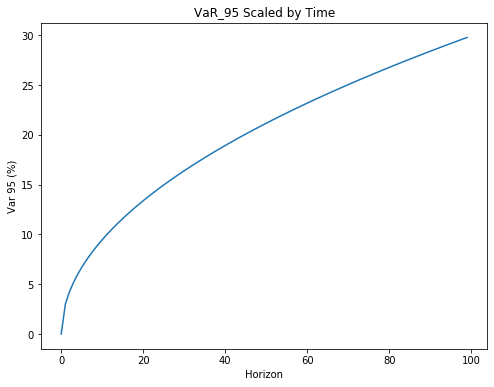

In [20]:
# Scaled VaR over different time horizon
plt.figure(figsize=(8,6))
plt.plot(range(100),[-100*VaR_95*np.sqrt(x) for x in range(100)])
plt.xlabel('Horizon')
plt.ylabel('Var 95 (%)')
plt.title('VaR_95 Scaled by Time');


<h3 id="Historical-VaR">Historical VaR<a class="anchor-link" href="#Historical-VaR">¶</a></h3><p>Asset returns do not necessarily follow a normal distribution. An alternative is to use sorted returns to evaluate a VaR. This method uses historical data where returns are sorted in ascending order to calculate maximum possible loss for a given confidence level.</p>


In [21]:
# Use quantile function for Historical VaR
hVaR_90 = returns['AMZN'].quantile(0.10)
hVaR_95 = returns['AMZN'].quantile(0.05)
hVaR_99 = returns['AMZN'].quantile(0.01)

In [22]:
htable = [['90%', hVaR_90],['95%', hVaR_95],['99%', hVaR_99]]
print(tabulate(htable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0176864
95%                      -0.0270757
99%                      -0.0537678



<h3 id="Expected-Short-Fall">Expected Short Fall<a class="anchor-link" href="#Expected-Short-Fall">¶</a></h3><p>VaR is a reasonable measure of risk if assumption of normality holds. Else, we might underestimate the risk if we observe <strong>a fat tail or overestimate the risk if tail is thinner</strong>. Expected shortfall or Conditional Value at Risk - <strong>CVaR</strong> - is an estimate of expected shortfall sustained in the worst 1 - x% of scenarios. It is defined as the average loss based on the returns that are lower than the VaR threshold. Assume that we have <em><code>n</code></em> return observations, then the expected shortfall is
<br/><br/>
$$ CVaR = \frac 1 n * \sum_{i=1}^{n} R_i[R \leq hVaR_{cl}]$$</p>
<p>where, $R$ is returns, $hVaR$ is historical VaR and $cl$ is the confidence level.</p>


In [23]:
# Calculate CVar
CVaR_90 = returns['AMZN'][returns['AMZN']<=hVaR_90].mean()
CVaR_95 = returns['AMZN'][returns['AMZN']<=hVaR_95].mean()
CVaR_99 = returns['AMZN'][returns['AMZN']<=hVaR_99].mean()

In [24]:
ctable = [['90%', CVaR_90],['95%', CVaR_95],['99%', CVaR_99] ]
cheader = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(ctable,headers=cheader))

Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                  -0.0322919
95%                                  -0.0430837
99%                                  -0.0709137



<h3 id="MonteCarlo-VaR">MonteCarlo VaR<a class="anchor-link" href="#MonteCarlo-VaR">¶</a></h3><p>The Monte Carlo simulation approach has a number of similarities to historical simulation. It allows us to use actual historical distributions rather than having to assume normal returns. As returns are assumed to follow a normal distribution, we could generate <em><code>n</code></em> simulated returns with the same mean and standard deviation (derived from the daily returns) and then sorted in ascending order to calculate maximum possible loss for a given confidence level.</p>


In [25]:
# Set seed for reproducibility
np.random.seed(12345)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns,10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns,1)

In [26]:
mctable = [['90%', MCVaR_90],['95%', MCVaR_95],['99%', MCVaR_99]]
print(tabulate(mctable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.022716
95%                      -0.0296045
99%                      -0.0419563



<h2 id="Portfolio-VaR">Portfolio VaR<a class="anchor-link" href="#Portfolio-VaR">¶</a></h2><p>If we know the returns and volatilities of all the assets in the portfolio, we can calculate the VaR for the whole portfolio. We will now derive VaR of an equal weighted portfolio of FAANG stocks.</p>



<h3 id="Assign-Weights">Assign Weights<a class="anchor-link" href="#Assign-Weights">¶</a></h3>


In [27]:
wts = np.array([0.2,0.2,0.2,0.2,0.2])[:,np.newaxis]
wts

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])


<h3 id="Portfolio-return">Portfolio return<a class="anchor-link" href="#Portfolio-return">¶</a></h3>


In [28]:
# Stock returns
returns[:5]

,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2013-01-03,-0.012623,0.004547,-0.008214,0.000581,0.049777
2013-01-04,-0.027855,0.002592,0.035650,0.019760,-0.006315
2013-01-07,-0.005882,0.035925,0.022949,-0.004363,0.033549
2013-01-08,0.002692,-0.007748,-0.012237,-0.001974,-0.020565
2013-01-09,-0.015629,-0.000113,0.052650,0.006573,-0.012865


In [29]:
port_ret = np.dot(returns,wts)
port_ret.flatten()

array([ 0.00681364,  0.00476646,  0.01643538, ..., -0.00763758,
       -0.02829639,  0.04543993])

In [30]:
port_mean = port_ret.mean()
port_mean

0.0013435993118931643


<h3 id="Portfolio-Volatility">Portfolio Volatility<a class="anchor-link" href="#Portfolio-Volatility">¶</a></h3>


In [31]:
# Covariance matrix
returns.cov()

,AAPL,AMZN,FB,GOOG,NFLX
AAPL,0.000304,0.000140,0.000160,0.000148,0.000126
AMZN,0.000140,0.000363,0.000205,0.000185,0.000243
FB,0.000160,0.000205,0.000460,0.000192,0.000215
GOOG,0.000148,0.000185,0.000192,0.000258,0.000195
NFLX,0.000126,0.000243,0.000215,0.000195,0.000852


In [32]:
# Portfolio volatility
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
port_stdev.flatten()[0]

0.015303544566859555


<h3 id="Portfolio-Position">Portfolio Position<a class="anchor-link" href="#Portfolio-Position">¶</a></h3>


In [33]:
# Portfolio Position
port_pos = (df.iloc[-1] * num_of_shares).sum()
port_pos

4607223.205566406

In [34]:
# Calculate Portfolio VaR at difference confidence level
pVaR_90 = norm.ppf(1-0.90,port_mean,port_stdev).flatten()[0]
pVaR_95 = norm.ppf(1-0.95,port_mean,port_stdev).flatten()[0]
pVaR_99 = norm.ppf(1-0.99,port_mean,port_stdev).flatten()[0]

In [35]:
pVaR_95

-0.02382849147411927


<h3 id="Portfolio-VaR">Portfolio VaR<a class="anchor-link" href="#Portfolio-VaR">¶</a></h3>


In [36]:
# Ouput results in tabular format
ptable = [['90%', pVaR_90],['95%', pVaR_95],['99%', pVaR_99]]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(ptable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0182687
95%                      -0.0238285
99%                      -0.0342578



<p>Let's now compare the portfolio VaR numbers with that of the individual stocks</p>


In [37]:
# Iterate over symbols
for stock in df.columns:
    pos = df[stock].iloc[-1] * num_of_shares
    pvar = pos * VaR(stock)
    
    print(f'{stock} Holding Value: {pos:0.4}') 
    print(f'{stock} VaR at 95% confidence level: {pvar:0.4}')
    print()

print(f'Portfolio Holding Value: {port_pos:0.4}')
print(f'Portoflio VaR at 95% confidence level: {port_pos * pVaR_95:0.4}')

AAPL Holding Value: 2.87e+05
AAPL VaR at 95% confidence level: -7.965e+05

AMZN Holding Value: 2.373e+06
AMZN VaR at 95% confidence level: -7.101e+06

FB Holding Value: 1.942e+05
FB VaR at 95% confidence level: -6.603e+05

GOOG Holding Value: 1.341e+06
GOOG VaR at 95% confidence level: -3.432e+06

NFLX Holding Value: 4.119e+05
NFLX VaR at 95% confidence level: -1.884e+06

Portfolio Holding Value: 4.607e+06
Portoflio VaR at 95% confidence level: -1.098e+05



<p>The VaR for the current portfolio of $\$ 4.6$ million is \$109,356, which is much lesser than the individual VaR numbers. This signifies the effect of diversification by selecting different stocks.</p>



<h1 id="References">References<a class="anchor-link" href="#References">¶</a></h1><ul>
<li><p>Numpy documentation <a href="https://docs.scipy.org/doc/numpy/">https://docs.scipy.org/doc/numpy/</a></p>
</li>
<li><p>Scipy documentation <a href="https://docs.scipy.org/doc/scipy/reference/">https://docs.scipy.org/doc/scipy/reference/</a></p>
</li>
<li><p>Paul Wilmott (2007), Paul Wilmott introduces Quantitative Finance</p>
</li>
</ul>
